# Reproducing figure 17 of Billangeon et al.

This notebook computes the Hamiltonian of the tunable gap flux qubit capacitively coupled to a quantum harmonic oscillator circuit shown in figure 16 of Billangeon. 

<center><img src="images/fig_16.png" width=600 height=600/></center>
<center>Figure 16: Qubit + Resonator Circuit</center>

It then goes on to compute the parameters of the approximated Hamiltonian

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_z \left( a^\dagger + a \right)
\end{equation}

with the aim of reproducing the behaviour seen in figure 17.

<center><img src="images/fig_17.png" width=800 height=800/></center>
<center>Figure 17: Figures to reproduce</center>

## Install and Import Required Packages

In [2]:
%%capture out
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install tdqm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse

from tqdm import tqdm

## Initialise Constants

In [3]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

## Construct System Class

In [4]:
class System:
    
    def __init__(self, EJ=121e9, CJ=8e-15, Cr=100e-15, Cc=5e-15, Lr=10e-9, alpha=0.4, ng=0.25, flux=0, ncut=2, mcut=20):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ = EJ * self.h                   # Josephson energy
        self.CJ = CJ                            # Josephson capacitance
        self.Cr = Cr                            # Resonator capacitance
        self.Cc = Cc                            # Coupling capacitance
        self.Lr = Lr                            # Resonator inductance
        self.alpha = alpha                      # Asymmetry of flux qubit
        self.ng = ng                            # Reduced gate charge
        self.flux = flux * self.flux_quanta     # Flux through qubit
        self.Z0 = np.sqrt(self.Lr / self.Cr)    # Impedance of resonator
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.mcut = mcut                        # Cut-off threshold for resonator Fock states
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = np.diag(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        self.I_fb = np.diag(np.ones(self.mcut))           # Identity for resonator (Fock basis)
        
        self.q_op_cb = np.diag(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = np.diag(np.ones(2 * self.ncut, dtype=np.complex_), k=1)                                   # e^{i \phi} operator (charge basis)
        self.creation_op_fb = np.diag(np.sqrt(np.arange(1, self.mcut, dtype=np.complex_)), k=-1)                      # Creation operator (Fock basis)
        self.annihilation_op_fb = np.conjugate(self.creation_op_fb.T)                                                 # Annihilation operator (Fock basis)
        self.q_op_fb = np.sqrt(self.hbar / (2 * self.Z0)) * 1j * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb = np.sqrt(self.hbar * self.Z0 * 0.5) * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        
        self.q1_q1_qr = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_fb)
        self.q1_q2_qr = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_fb)
        self.q1_q3_qr = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q1_q4_qr = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_fb)
        self.q2_q2_qr = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_fb)
        self.q2_q3_qr = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q2_q4_qr = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_fb)
        self.q3_q3_qr = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_fb)
        self.q3_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_fb)
        self.q4_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_fb @ self.q_op_fb)
        
        self.q1_q = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_q = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_q = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_q = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_q = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_q = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_q = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_q = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return np.kron(np.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return np.kron(np.kron(np.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_mat_qr(self):
        self.init_operators()

        Csum = self.Cr + self.Cc
        Cstar = (self.Cr * self.Cc) / self.CJ
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * Csum + (1 + self.alpha) * self.Cr * self.Cc))

        kin_mat = (self.alpha * (2 + self.alpha) * Csum + (1 + self.alpha) * Cstar) * 0.5 * (self.q1_q1_qr + self.q2_q2_qr)
        kin_mat += self.alpha**2 * Csum * self.q1_q2_qr
        kin_mat += self.alpha * (1 + self.alpha) * Csum * (self.q1_q3_qr + self.q2_q3_qr)
        kin_mat += (1 + self.alpha)**2 * Csum * 0.5 * self.q3_q3_qr
        kin_mat += self.alpha * (1 + self.alpha) * self.Cc * (self.q1_q4_qr + self.q2_q4_qr)
        kin_mat += (1 + self.alpha)**2 * self.Cc * self.q3_q4_qr
        kin_mat += (1 + self.alpha) * (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc) * 0.5 * self.q4_q4_qr
        
        kin_mat = kin_mat / C0**2

        return kin_mat

    def pot_mat_qr(self):
        self.init_operators()
        
        pot_mat = -self.EJ * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_fb)
        pot_mat += self.EJ * 2 * (1 + self.alpha) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_fb)
        pot_mat += 0.5 * self.Lr**-1 * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.phi_op_fb @ self.phi_op_fb)
        
        return pot_mat
        
    def kin_mat_q(self):
        self.init_operators()
        
        denom = 2 * self.alpha**2 * (1 + self.alpha) * self.CJ**3

        kin_mat = self.alpha * (1 + 2 * self.alpha) * self.CJ**2 * (self.q1_q1_q + self.q2_q2_q)
        kin_mat += 2 * self.alpha * self.CJ**2 * self.q1_q2_q
        kin_mat += 2 * self.alpha * (1 + self.alpha) * self.CJ**2 * (self.q1_q3_q + self.q2_q3_q)
        kin_mat += self.CJ**2 * (1 + self.alpha)**2 * self.q3_q3_q

        kin_mat = kin_mat / denom
        
        return kin_mat

    def pot_mat_q(self):
        self.init_operators()

        pot_mat = -self.EJ * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_mat += -self.EJ * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_mat += self.EJ * 2 * (1 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_mat

    def get_H_qr(self):
        self.H_qr = self.kin_mat_qr() + self.pot_mat_qr()
        
        return self.H_qr

    def get_H_q(self):
        self.H_q = self.kin_mat_q() + self.pot_mat_q()
        
        return self.H_q
    
    def diagonalise_qr(self, update=False):
        if update:
            self.get_H_qr()
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()
        
        self.evals_qr, self.evecs_qr = sp.linalg.eigh(
            self.H_qr, eigvals=(0, 1), eigvals_only=False
        )

        self.evecs_qr = self.evecs_qr.T
        
        return self.evals_qr, self.evecs_qr
    
    def diagonalise_q(self, update=False):
        if update:
            self.get_H_q()
        else:
            try:
                self.H_q
            except AttributeError:
                self.get_H_q()
        
        self.evals_q, self.evecs_q = sp.linalg.eigh(
            self.H_q, eigvals=(0, 1), eigvals_only=False
        )

        self.evecs_q = self.evecs_q.T
        
        return self.evals_q, self.evecs_q
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_q(update=True)
        else:
            try:
                self.evecs_q
            except AttributeError:
                self.diagonalise_q()

        self.qubit_0 = self.evecs_q[0]
        self.qubit_1 = self.evecs_q[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        plt.plot(self.qubit_0)
        plt.show()
    
    def init_cavity_states(self):
        self.fock_0 = np.zeros((self.mcut,))
        self.fock_0[0] = 1

        self.fock_1 = np.zeros((self.mcut,))
        self.fock_1[1] = 1

        self.fock_m = 2**-0.5 * (self.fock_0 - self.fock_1)
        self.fock_p = 2**-0.5 * (self.fock_0 + self.fock_1)
        
    def init_prod_states(self, update=False):
        try:
            self.fock_0
        except AttributeError:
            self.init_cavity_states()

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = np.kron(self.qubit_0, self.fock_0)
        self.ket_01 = np.kron(self.qubit_0, self.fock_1)
        self.ket_10 = np.kron(self.qubit_1, self.fock_0)
        self.ket_11 = np.kron(self.qubit_1, self.fock_1)
        self.ket_0m = np.kron(self.qubit_0, self.fock_m)
        self.ket_0p = np.kron(self.qubit_0, self.fock_p)
        self.ket_p1 = np.kron(self.qubit_p, self.fock_1)
        self.ket_m0 = np.kron(self.qubit_m, self.fock_0)
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = 1j * self.hc(self.ket_p1) @ self.H_qr @ self.ket_m0
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11) @ self.H_qr @ self.ket_00
        
        return g_perp
    
    def calc_delta(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        delta = 2 * self.hc(self.ket_00) @ self.H_qr @ self.ket_00
        
        return delta
    
    def calc_omega(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        omega = self.hc(self.ket_01) @ self.H_qr @ self.ket_01 - 0.5 * self.calc_delta()
        
        return omega
    
    def calc_bil_omega(self):
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        omega_exp = self.hbar / np.sqrt(self.Lr * Cr_renorm)
        
        return omega_exp
    
    def calc_bil_coupling(self, update=False):
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * (self.Cr + self.Cc) + (1 + self.alpha) * self.Cr * self.Cc))

        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = np.sqrt(self.hbar / (2 * Zr_renorm))

        coupling_op = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q) + (1 + self.alpha)**2 * (self.Cc / C0**2) * self.q3_q

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        g_parr_bil = coeff * (self.hc(self.qubit_p) @ coupling_op @ self.qubit_m)
        g_perp_bil = coeff * (self.hc(self.qubit_1) @ coupling_op @ self.qubit_0)
        
        return g_parr_bil, g_perp_bil

In [35]:
class SparseSystem:
    
    def __init__(self, EJ=121e9, CJ=8e-15, Cr=100e-15, Cc=5e-15, Lr=10e-9, alpha=0.4, ng=0.25, flux=0, ncut=2, mcut=20):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ = EJ * self.h                   # Josephson energy
        self.CJ = CJ                            # Josephson capacitance
        self.Cr = Cr                            # Resonator capacitance
        self.Cc = Cc                            # Coupling capacitance
        self.Lr = Lr                            # Resonator inductance
        self.alpha = alpha                      # Asymmetry of flux qubit
        self.ng = ng                            # Reduced gate charge
        self.flux = flux * self.flux_quanta     # Flux through qubit
        self.Z0 = np.sqrt(self.Lr / self.Cr)    # Impedance of resonator
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.mcut = mcut                        # Cut-off threshold for resonator Fock states
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = sp.sparse.diags(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        self.I_fb = sp.sparse.diags(np.ones(self.mcut))           # Identity for resonator (Fock basis)
        
        self.q_op_cb = sp.sparse.diags(-2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = -2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = sp.sparse.diags(np.ones(2 * self.ncut, dtype=np.complex_), offsets=1)                                   # e^{i \phi} operator (charge basis)
        self.creation_op_fb = sp.sparse.diags(np.sqrt(np.arange(1, self.mcut, dtype=np.complex_)), offsets=-1)                      # Creation operator (Fock basis)
        self.annihilation_op_fb = np.conjugate(self.creation_op_fb.T)                                                 # Annihilation operator (Fock basis)
        self.q_op_fb = np.sqrt(self.hbar / (2 * self.Z0)) * 1j * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb = np.sqrt(self.hbar * self.Z0 * 0.5) * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        
        self.q1_q1_qr = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_fb)
        self.q1_q2_qr = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_fb)
        self.q1_q3_qr = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q1_q4_qr = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_fb)
        self.q2_q2_qr = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_fb)
        self.q2_q3_qr = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q2_q4_qr = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_fb)
        self.q3_q3_qr = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_fb)
        self.q3_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_fb)
        self.q4_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_fb @ self.q_op_fb)
        
        self.q1_q = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_q = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_q = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_q = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_q = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_q = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_q = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_q = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return sparse.kron(sparse.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return sparse.kron(sparse.kron(sparse.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_mat_qr(self):
        self.init_operators()

        Csum = self.Cr + self.Cc
        Cstar = (self.Cr * self.Cc) / self.CJ
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * Csum + (1 + self.alpha) * self.Cr * self.Cc))

        kin_mat = 0.5 * (self.alpha * (2 + self.alpha) * Csum + (1 + self.alpha) * Cstar) * (self.q1_q1_qr + self.q2_q2_qr)
        kin_mat += self.alpha**2 * Csum * self.q1_q2_qr
        kin_mat += self.alpha * (1 + self.alpha) * Csum * (self.q1_q3_qr + self.q2_q3_qr)
        kin_mat += 0.5 * (1 + self.alpha)**2 * Csum * self.q3_q3_qr
        kin_mat += self.alpha * (1 + self.alpha) * self.Cc * (self.q1_q4_qr + self.q2_q4_qr)
        kin_mat += (1 + self.alpha)**2 * self.Cc * self.q3_q4_qr
        kin_mat += 0.5 * (1 + self.alpha) * (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc) * self.q4_q4_qr
        
        kin_mat = kin_mat / C0**2

        return kin_mat

    def pot_mat_qr(self):
        self.init_operators()
        
        pot_mat = -self.EJ * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_fb)
        pot_mat += -self.EJ * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_fb)
        pot_mat += self.EJ * 2 * (1 + self.alpha) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_fb)
        pot_mat += 0.5 * self.Lr**-1 * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.phi_op_fb @ self.phi_op_fb)
        
        return pot_mat
        
    def kin_mat_q(self):
        self.init_operators()
        
        denom = 2 * self.alpha**2 * (1 + self.alpha) * self.CJ**3

        kin_mat = 0.5 * self.alpha * (1 + 2 * self.alpha) * self.CJ**2 * (self.q1_q1_q + self.q2_q2_q)
        kin_mat += self.alpha * self.CJ**2 * self.q1_q2_q
        kin_mat += self.alpha * (1 + self.alpha) * self.CJ**2 * (self.q1_q3_q + self.q2_q3_q)
        kin_mat += 0.5 * (1 + self.alpha)**2 * self.CJ**2 * self.q3_q3_q

        kin_mat = kin_mat / denom
        
        return kin_mat

    def pot_mat_q(self):
        self.init_operators()

        pot_mat = -self.EJ * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_mat += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_mat += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_mat += -self.EJ * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_mat += self.EJ * 2 * (1 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_mat

    def get_H_qr(self):
        self.H_qr = self.kin_mat_qr() + self.pot_mat_qr()
        self.H_qr.eliminate_zeros()
        
        return self.H_qr

    def get_H_q(self):
        self.H_q = self.kin_mat_q() + self.pot_mat_q()
        self.H_q.eliminate_zeros()
        
        return self.H_q
    
    def diagonalise_qr(self, update=False):
        if update:
            self.get_H_qr()
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()
        
        evals_qr, evecs_qr = sparse.linalg.eigs(
            self.H_qr, k=100, which='SR'
        )
        evecs_qr = evecs_qr.T
        
        args = np.argsort(evals_qr)
        self.evals_qr = evals_qr[args]
        self.evecs_qr = evecs_qr[args]
        
        return self.evals_qr, self.evecs_qr
    
    def diagonalise_q(self, update=False):
        if update:
            self.get_H_q()
        else:
            try:
                self.H_q
            except AttributeError:
                self.get_H_q()
        
        evals_q, evecs_q = sparse.linalg.eigs(
            self.H_q, 10, which='SR'
        )
        evecs_q = evecs_q.T
        
        args = np.argsort(evals_q)
        self.evals_q = evals_q[args]
        self.evecs_q = evecs_q[args]
        
        return self.evals_q, self.evecs_q
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_q(update=True)
        else:
            try:
                self.evecs_q
            except AttributeError:
                self.diagonalise_q()

        self.qubit_0 = self.evecs_q[0]
        self.qubit_1 = self.evecs_q[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |0>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_0))
        plt.plot(np.imag(self.qubit_0))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |1>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_1))
        plt.plot(np.imag(self.qubit_1))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |+>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_p))
        plt.plot(np.imag(self.qubit_p))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |->, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_m))
        plt.plot(np.imag(self.qubit_m))
        plt.show()
    
    def init_cavity_states(self):
        self.fock_0 = np.zeros((self.mcut,))
        self.fock_0[0] = 1

        self.fock_1 = np.zeros((self.mcut,))
        self.fock_1[1] = 1

        self.fock_m = 2**-0.5 * (self.fock_0 - self.fock_1)
        self.fock_p = 2**-0.5 * (self.fock_0 + self.fock_1)
        
    def init_prod_states(self, update=False):
        try:
            self.fock_0
        except AttributeError:
            self.init_cavity_states()

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = np.kron(self.qubit_0, self.fock_0)
        self.ket_01 = np.kron(self.qubit_0, self.fock_1)
        self.ket_10 = np.kron(self.qubit_1, self.fock_0)
        self.ket_11 = np.kron(self.qubit_1, self.fock_1)
        self.ket_0m = np.kron(self.qubit_0, self.fock_m)
        self.ket_0p = np.kron(self.qubit_0, self.fock_p)
        self.ket_p1 = np.kron(self.qubit_p, self.fock_1)
        self.ket_m0 = np.kron(self.qubit_m, self.fock_0)
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = 1j * self.hc(self.ket_p1) @ self.H_qr @ self.ket_m0
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11) @ self.H_qr @ self.ket_00
        
        return g_perp
    
    def calc_delta(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        delta = 2 * self.hc(self.ket_00) @ self.H_qr @ self.ket_00
        
        return delta
    
    def calc_omega(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        omega = self.hc(self.ket_01) @ self.H_qr @ self.ket_01 - 0.5 * self.calc_delta()
        
        return omega
    
    def calc_bil_omega(self):
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        omega_exp = self.hbar / np.sqrt(self.Lr * Cr_renorm)
        
        return omega_exp
    
    def calc_bil_coupling(self, update=False):
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * (self.Cr + self.Cc) + (1 + self.alpha) * self.Cr * self.Cc))

        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = np.sqrt(self.hbar / (2 * Zr_renorm))

        coupling_op = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q) + (1 + self.alpha)**2 * (self.Cc / C0**2) * self.q3_q

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        g_parr_bil = -1 * coeff * (self.hc(self.qubit_p) @ coupling_op @ self.qubit_m)
        g_perp_bil = coeff * (self.hc(self.qubit_1) @ coupling_op @ self.qubit_0)
        
        return g_parr_bil, g_perp_bil

## Visualise Hamiltonians

/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


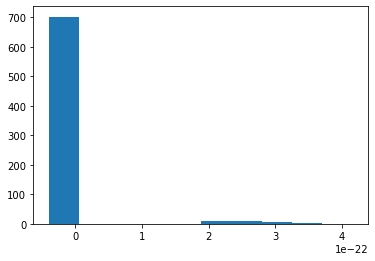

In [6]:
system = SparseSystem(ncut=1, alpha=0.25)
H_q = system.get_H_q()

plt.hist(H_q.toarray().flatten())
plt.show()

100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.78it/s]
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


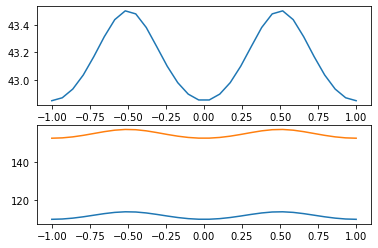

In [7]:
ngs = np.linspace(-1, 1, 30)
E0s = []
E1s = []
E10s = []

system = SparseSystem(ncut=4, alpha=0.25)

for ng in tqdm(ngs):
    
    system.ng = ng
    
    evals, evecs = system.diagonalise_q(update=True)
    evals = evals * 1e-9 / h
    
    E10 = evals[1] - evals[0]
    
    # E10 = system.qubit_diff(update=True)
    
    E0s.append(evals[0])
    E1s.append(evals[1])
    E10s.append(E10)

plt.subplot(211)
plt.plot(ngs, E10s)
plt.subplot(212)
plt.plot(ngs, E0s)
plt.plot(ngs, E1s)
plt.show()

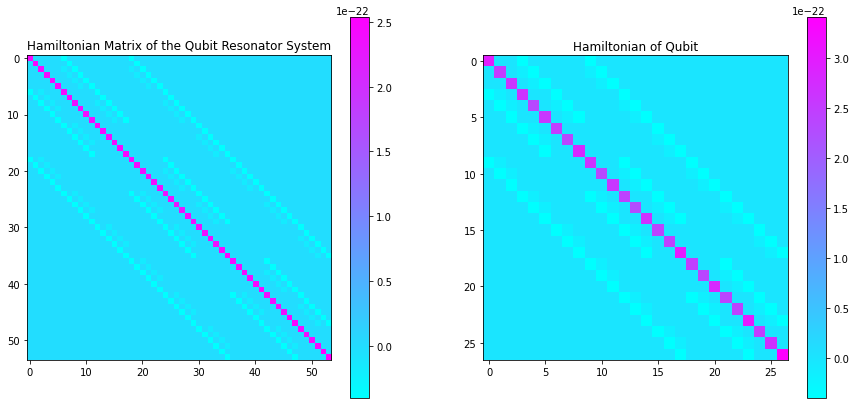

In [8]:
system = SparseSystem(ncut=1, mcut=2)

H_qr = system.get_H_qr()
H_q = system.get_H_q()

if type(H_q) == scipy.sparse.csr.csr_matrix:
    H_q = H_q.toarray()
    H_qr = H_qr.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Hamiltonian Matrix of the Qubit Resonator System')
im1 = ax1.imshow(np.real(H_qr), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Hamiltonian of Qubit')
im2 = ax2.imshow(np.real(H_q), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_x \left( a^\dagger + a \right)
\end{equation}

which when writing the two subspaces explicitly is written as

\begin{equation}
    H = \omega_r' \mathbb{1} \otimes a^\dagger a + \frac{\Delta}{2} \sigma_z \otimes \mathbb{1} + i g_{\parallel} \sigma_z \otimes \left( a^\dagger - a \right) + g_{\perp} \sigma_x \otimes \left( a^\dagger + a \right)
\end{equation}

To find the parameters we can evaluate the following overlaps:

\begin{equation}
    \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle 0 | \langle 1 | H | 0 \rangle | 1 \rangle = \omega_r' + \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle + | \langle 1 | H | - \rangle | 0 \rangle = i g_{\parallel}
\end{equation}

\begin{equation}
    \langle 1 | \langle 1 | H | 0 \rangle | 0 \rangle = g_{\perp}
\end{equation}

where we use the notation $| \text{Qubit} \rangle | \text{Cavity} \rangle$

### Evaluate parameters

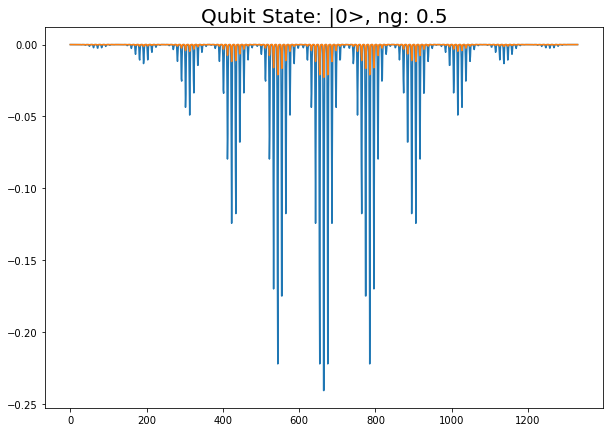

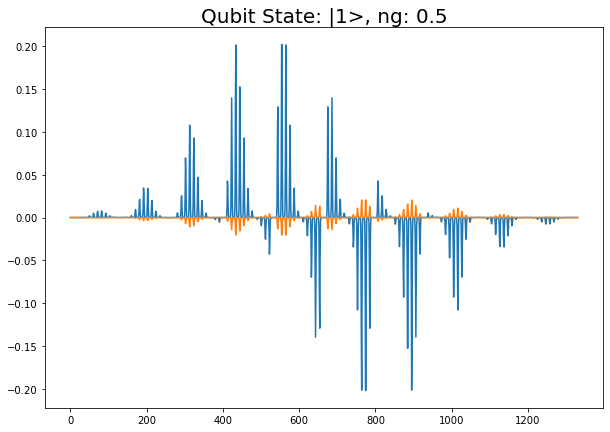

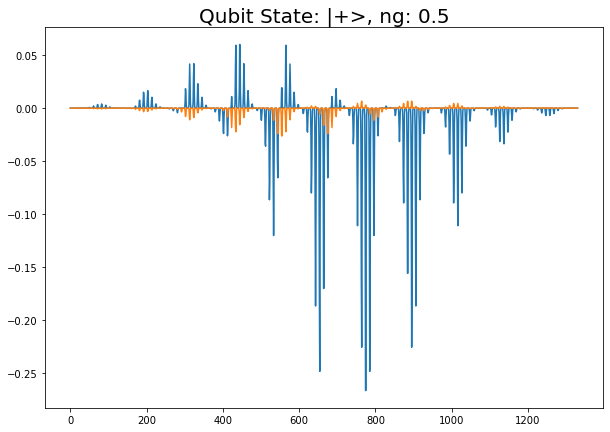

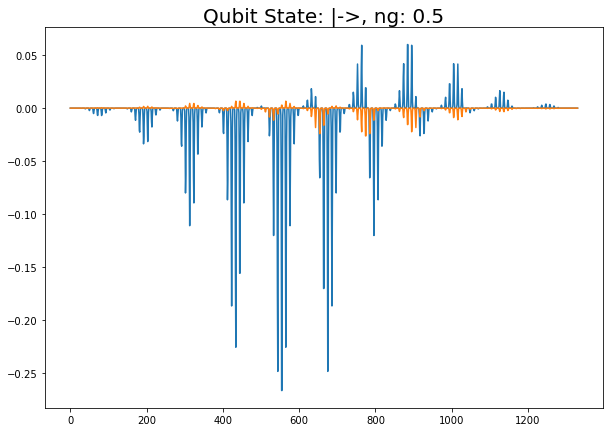

In [36]:
system = SparseSystem(ncut=5, mcut=2, ng=0.5)
H_q = system._plot_qubit_states()

In [25]:
system = SparseSystem(ncut=5, ng=0.5)

g_parr = system.calc_g_parr()
print(f"g parallel: {g_parr}")

g_perp = system.calc_g_perp()
print(f"g perpendicular: {g_perp}")

delta = system.calc_delta()
print(f"delta: {delta}")

omega = system.calc_omega()
print(f"omega: {omega}")

g parallel: (3.812155620193794e-33-1.2529070910547392e-39j)
g perpendicular: (-1.2563558744301151e-39+1.7679619650730983e-40j)
delta: (9.870009358869639e-23-1.7632415262334313e-38j)
omega: (3.2972967748425276e-24+2.938735877055719e-39j)


### Expected $\omega_r'$

Here we compute the expected resonant frequency of the resonator using the equation

\begin{equation}
    \omega_r' = \hbar / \sqrt{L_r C_r'}
\end{equation}

where $C_r'$ is the renormalised resonator capacitance, as defined in eq A16.

In [7]:
omega_exp = system.calc_bil_omega()
print(f"omega exp: {omega_exp}")

omega exp: 3.2970672320050607e-24


## Calculating Coupling with Eq A15 

In Billangeon et al they express the coupling parameters as:

\begin{equation}
    g_\perp = \langle 1 | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | 0 \rangle
\end{equation}

\begin{equation}
    g_\parallel = \langle + | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | - \rangle
\end{equation}

In [78]:
g_parr_bil, g_perp_bil = system.calc_bil_coupling()

print(f"g parallel: {g_parr_bil}")
print(f"g perpendicular: {g_perp_bil}")

g parallel: (9.7031830847937e-29+3.7649973029463585e-40j)
g perpendicular: (-4.156251799558828e-40-3.841468031044505e-40j)


## Figure 17a

In [79]:
system = SparseSystem(ncut=4)
system.Cc = 0
ngs = np.linspace(-1, 1, 30)
alphas = [0.25, 0.6]
fig17a_data = {}

for alpha in alphas:
    system.alpha = alpha
    fig17a_data[alpha] = []
    for ng in tqdm(ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_delta(update=True)
        fig17a_data[alpha].append(delta)

100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.54it/s]


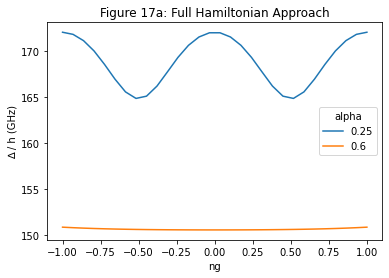

In [80]:
plt.title('Figure 17a: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for alpha in fig17a_data.keys():
    plt.plot(ngs, [np.real(delta * 1e-9) / h for delta in fig17a_data[alpha]], label=alpha)
plt.legend(title='alpha')
plt.show()

## Figure 17b

In [82]:
system = SparseSystem(ncut=5, alpha=0.4)
ngs = np.linspace(-1, 1, 30)
Ccs = [0, 10e-15]
fig17b_data = {}

for Cc in Ccs:
    system.Cc = Cc
    fig17b_data[Cc] = []
    for ng in tqdm(ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_delta(update=True)
        fig17b_data[Cc].append(delta)

100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]


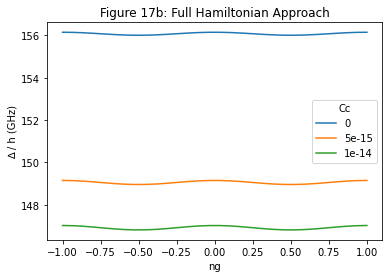

In [83]:
plt.title('Figure 17b: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for Cc in fig17b_data.keys():
    plt.plot(ngs, [np.real(delta * 1e-9) / h for delta in fig17b_data[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

## Figure 17c

In [85]:
system = SparseSystem(ncut=5, alpha=0.4)
ngs = np.linspace(-1, 1, 30)
Ccs = [1e-15, 8e-15]
fig17c_data = {}

for Cc in Ccs:
    system.Cc = Cc
    fig17c_data[Cc] = []
    for ng in tqdm(ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17c_data[Cc].append(g_parr)

100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.93it/s]


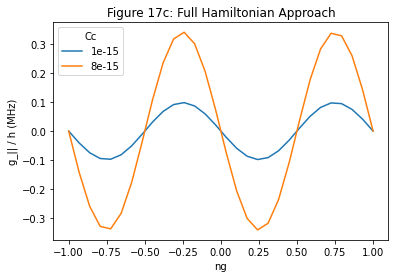

In [86]:
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')
for Cc in fig17c_data.keys():
    plt.plot(ngs, [np.real(g_parr * 1e-6) / h for g_parr in fig17c_data[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

## Varying Cc (Figure 17d)

In [111]:
system = SparseSystem(ncut=8, alpha=0.4, mcut=20, ng=0.5)

Ccs = np.linspace(0, 1e-14, 20)
fig17d_data = {}
fig17d_data['FH'] = []
fig17d_data['Bil'] = []

for Cc in tqdm(Ccs):
    system.Cc = Cc
    
    # Full Hamiltonina Approach
    g_parr = system.calc_g_parr(update=True)
    fig17d_data['FH'].append(g_parr)

    # Billangeon Eq A15 Approach
    g_parr_bil, g_perp_bil = system.calc_bil_coupling(update=True)
    fig17d_data['Bil'].append(g_parr_bil)

100%|███████████████████████████████████████████| 20/20 [00:26<00:00,  1.35s/it]


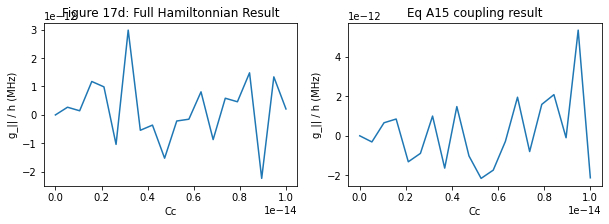

In [112]:
f = plt.figure(figsize=(10,3))

ax1 = f.add_subplot(121)
ax1.title.set_text('Figure 17d: Full Hamiltonnian Result')
ax1.set_xlabel('Cc')
ax1.set_ylabel('g_|| / h (MHz)')
ax1.plot(Ccs, [np.real(g_parr * 1e-6) / h for g_parr in fig17d_data['FH']])

ax2 = f.add_subplot(122)
ax2.title.set_text('Eq A15 coupling result')
ax2.set_xlabel('Cc')
ax2.set_ylabel('g_|| / h (MHz)')
ax2.plot(Ccs, [np.real(g_parr_bil * 1e-6) / h for g_parr_bil in fig17d_data['Bil']])
plt.show()